In [1]:
!pip install -q pandas_datareader

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from pandas.tseries.offsets import DateOffset

# Load the Data

In [3]:
# Load data from FRED
start_date = '1990-01-01'
end_date = None  # Fetch up to the most recent data

# Fetch the 'Industrial Production: Electric and gas utilities' data
data = pdr.DataReader('IPG2211A2N', 'fred', start=start_date, end=end_date)
data.dropna(inplace=True)

# Extract the 'IPG2211A2N' column as a Series
series = data['IPG2211A2N']
series.name = 'Electric Production'

In [4]:
print(type(series))

<class 'pandas.core.series.Series'>


In [5]:
# Ensure the index is datetime
series.index = pd.to_datetime(series.index)

# Display the first and last few rows
display(series.head())
print("\n")
display(series.tail())

,Electric Production
DATE,
1990-01-01,83.3799
1990-02-01,76.2653
1990-03-01,72.3234
1990-04-01,66.4556
1990-05-01,65.0281


,Electric Production
DATE,
2024-05-01,95.6705
2024-06-01,108.8832
2024-07-01,119.9540
2024-08-01,118.4844
2024-09-01,104.8967


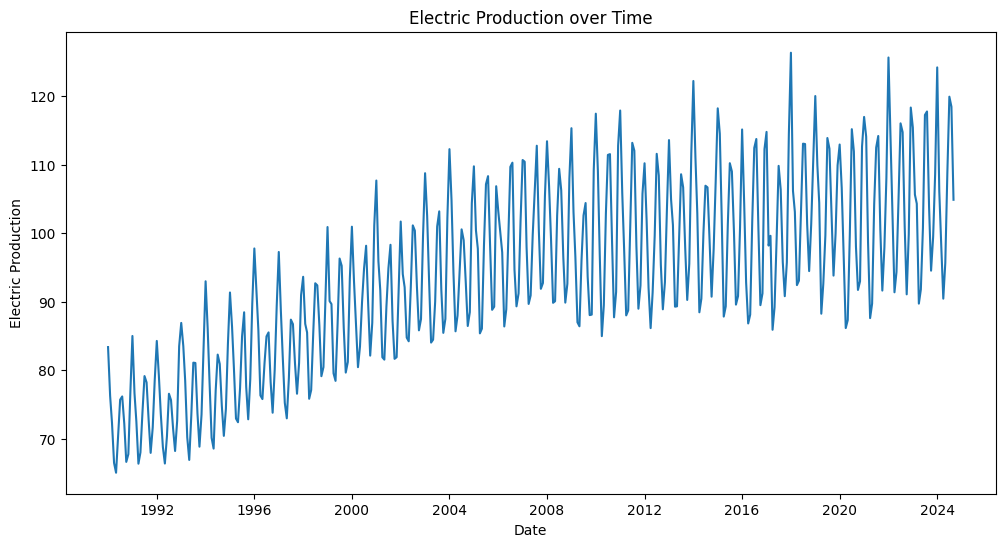

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(series.index, series.values)
plt.title('Electric Production over Time')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.show()

# Traditional GA

In [7]:
def calculate_fitness_traditional(candidate, expected_value):
    return 1 / np.abs(candidate - expected_value + 1e-6)  # Add small value to avoid division by zero

In [8]:
def genetic_algorithm_traditional(train_data, generations=100, mutation_rate=0.3, n_months=3):
    # Initialize the population with the last few values
    population = train_data[-(n_months + 5):].tolist()  # Start with the last few values
    expected_values = [train_data.iloc[-1] + i for i in range(1, n_months + 1)]  # Simple linear trend

    forecasted_values = []

    for i in range(n_months):
        expected_value = expected_values[i]
        for generation in range(generations):
            # Calculate fitness for each candidate
            fitness_scores = [calculate_fitness_traditional(x, expected_value) for x in population]

            # Selection: pick two best candidates
            selected_indices = np.argsort(fitness_scores)[-2:]  # Indices of top 2 candidates
            parents = [population[i] for i in selected_indices]

            # Crossover: average the parents
            offspring = (parents[0] + parents[1]) / 2

            # Mutation: add some randomness
            mutated_offspring = offspring + mutation_rate * np.random.randn()

            # Update the population
            population.append(mutated_offspring)
            population.pop(0)  # Remove the oldest candidate to keep population size constant

        # Store the best candidate as the forecasted value
        forecasted_values.append(population[-1])

    return forecasted_values

In [9]:
def forecast_next_n_months_traditional(train_data, test_data, n_months=3):
    # Forecast the next N months using the genetic algorithm
    forecasted_values = genetic_algorithm_traditional(train_data, n_months=n_months)

    # Calculate the average of the actual last N months (holdout set)
    actual_avg_last_n_months = test_data[-n_months:].mean()

    # Calculate performance metrics (MAPE, RMSE)
    mape = mean_absolute_percentage_error([actual_avg_last_n_months], [np.mean(forecasted_values)])
    rmse = np.sqrt(mean_squared_error([actual_avg_last_n_months], [np.mean(forecasted_values)]))

    # Display results
    print(f"Forecasted Values for next {n_months} months: {forecasted_values}")
    print(f"Actual Average of Last {n_months} Months: {actual_avg_last_n_months}")
    print(f"MAPE: {mape}")
    print(f"RMSE: {rmse}")

    return forecasted_values, mape, rmse

In [10]:
# Forecasting 1 month
print("Traditional GA Forecasting - Next 1 Month:")
forecasted_values_1, mape_1, rmse_1 = forecast_next_n_months_traditional(series[:-1], series[-1:], n_months=1)

# Forecasting 3 months
print("\nTraditional GA Forecasting - Next 3 Months:")
forecasted_values_3, mape_3, rmse_3 = forecast_next_n_months_traditional(series[:-3], series[-3:], n_months=3)

# Forecasting 5 months
print("\nTraditional GA Forecasting - Next 5 Months:")
forecasted_values_5, mape_5, rmse_5 = forecast_next_n_months_traditional(series[:-5], series[-5:], n_months=5)

Traditional GA Forecasting - Next 1 Month:
Forecasted Values for next 1 months: [119.05044303250317]
Actual Average of Last 1 Months: 104.8967
MAPE: 0.13493029840312587
RMSE: 14.153743032503172

Traditional GA Forecasting - Next 3 Months:
Forecasted Values for next 3 months: [110.27702361343694, 111.41538140112776, 111.75858897113679]
Actual Average of Last 3 Months: 114.44503333333334
MAPE: 0.02878851015902101
RMSE: 3.2947020047661653

Traditional GA Forecasting - Next 5 Months:
Forecasted Values for next 5 months: [91.7689605014263, 92.64619086904663, 93.59709793266336, 94.02960618539588, 95.43913471945817]
Actual Average of Last 5 Months: 109.57775999999998
MAPE: 0.14675936027896466
RMSE: 16.08156195840192


In [11]:
def plot_forecast_traditional(actual_data, test_data, forecasted_values, n_months):
    # Create a date range for the forecasted values
    last_date = actual_data.index[-1]
    forecast_dates = pd.date_range(start=last_date + DateOffset(months=1), periods=n_months, freq='MS')

    # Plot the actual data
    plt.figure(figsize=(12, 6))
    plt.plot(actual_data.index, actual_data.values, label='Training Data')

    # Plot the test data (actual future data)
    plt.plot(test_data.index[:n_months], test_data.values[:n_months], label='Actual Future Data')

    # Plot the forecasted values
    plt.plot(forecast_dates, forecasted_values, label='Forecasted Values', linestyle='--')

    plt.title(f'Traditional GA Forecasting - Next {n_months} Months')
    plt.xlabel('Date')
    plt.ylabel('Electric Production')
    plt.legend()
    plt.show()

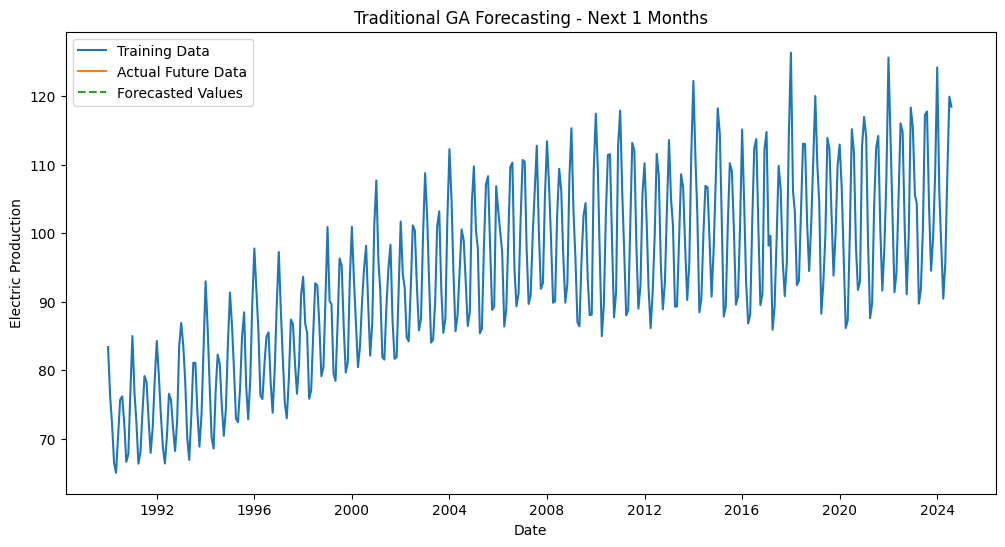

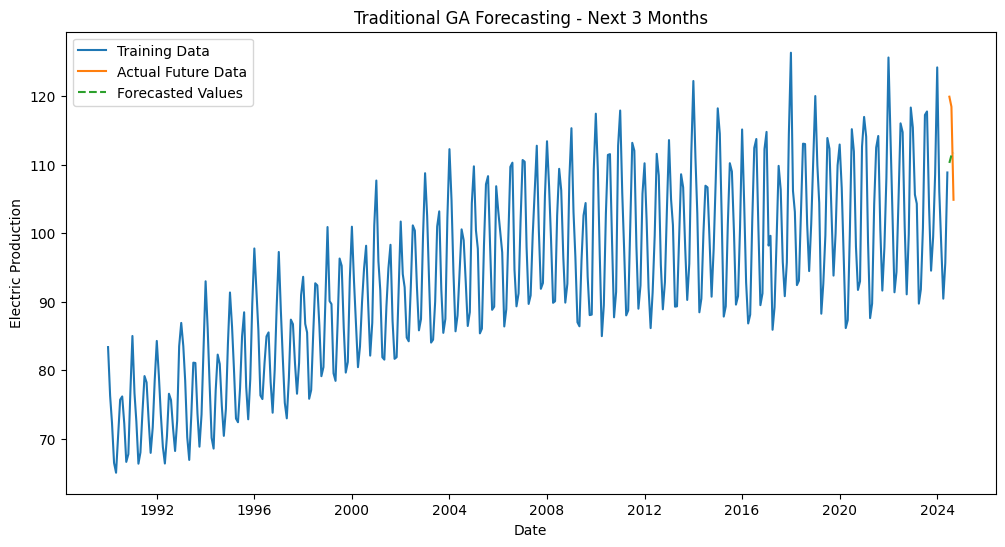

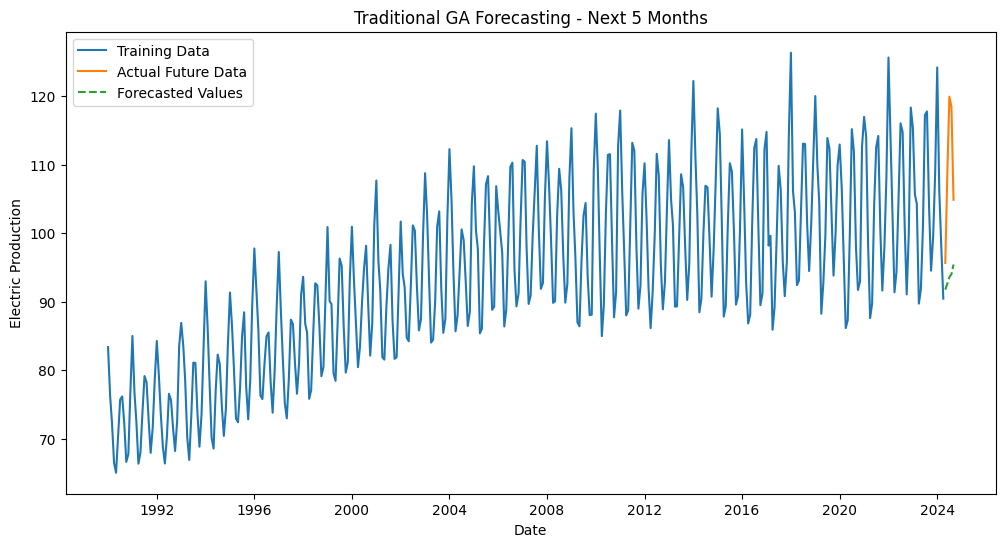

In [12]:
# Plot forecasts
plot_forecast_traditional(series[:-1], series[-1:], forecasted_values_1, n_months=1)
plot_forecast_traditional(series[:-3], series[-3:], forecasted_values_3, n_months=3)
plot_forecast_traditional(series[:-5], series[-5:], forecasted_values_5, n_months=5)

In [13]:
def plot_forecast_traditional(actual_data, test_data, forecasted_values, n_months):
    import matplotlib.dates as mdates
    from matplotlib.dates import DateFormatter

    # Create a date range for the forecasted values
    last_date = actual_data.index[-1]
    forecast_dates = pd.date_range(start=last_date + DateOffset(months=1), periods=n_months, freq='MS')

    # Combine actual and forecasted data for plotting
    combined_dates = actual_data.index.append(forecast_dates)
    combined_values = np.concatenate([actual_data.values, forecasted_values])

    # Plot the actual data
    plt.figure(figsize=(14, 7))
    plt.plot(actual_data.index, actual_data.values, label='Training Data', color='blue', linewidth=2)

    # Plot the test data (actual future data)
    plt.plot(test_data.index[:n_months], test_data.values[:n_months], label='Actual Future Data',
             color='green', linestyle='-', marker='o', linewidth=2)

    # Plot the forecasted values
    plt.plot(forecast_dates, forecasted_values, label='Forecasted Values', color='red',
             linestyle='--', marker='x', markersize=8, linewidth=2)

    # Shade the forecast period
    plt.axvspan(forecast_dates[0], forecast_dates[-1], color='orange', alpha=0.2)

    # Add vertical line to indicate forecast start
    plt.axvline(x=last_date, color='black', linestyle='--', linewidth=1)

    # Set x-axis limits to focus on the recent data (last 24 months)
    plt.xlim([actual_data.index[-24], forecast_dates[-1] + DateOffset(months=1)])

    # Improve date formatting on x-axis
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.title(f'Traditional GA Forecasting - Next {n_months} Months', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Electric Production', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

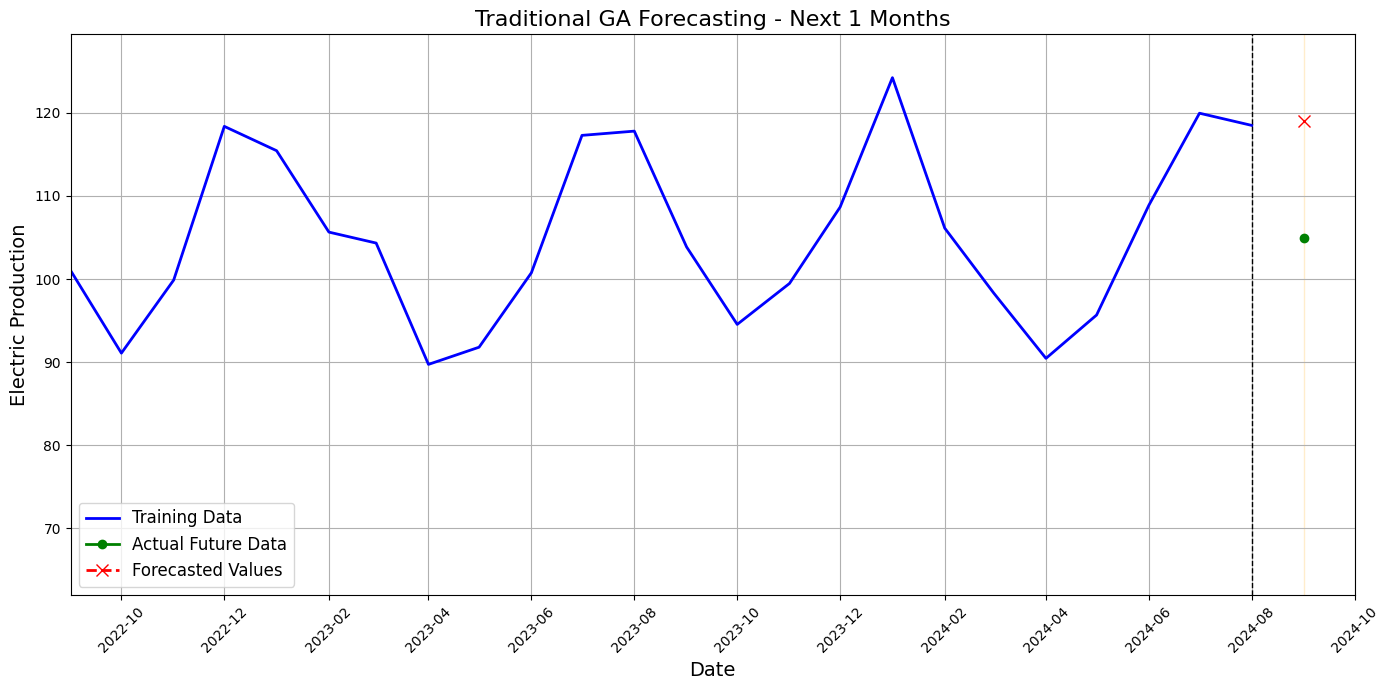

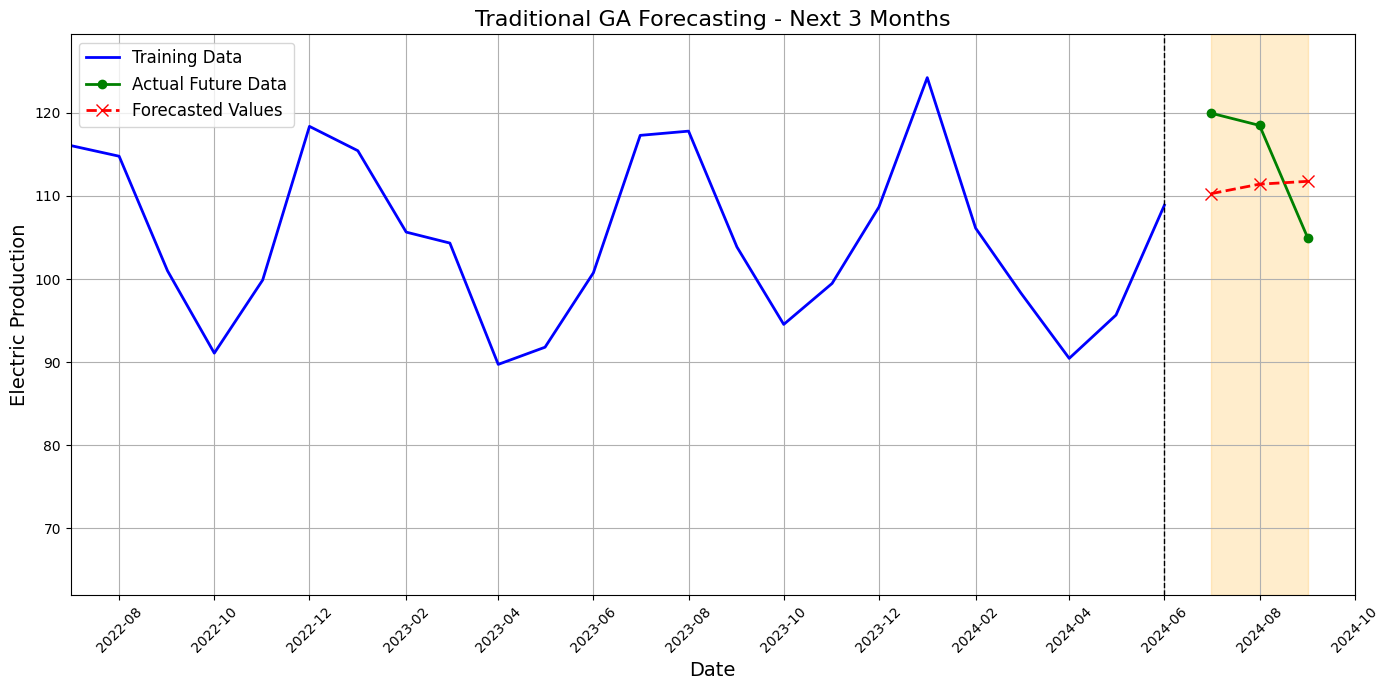

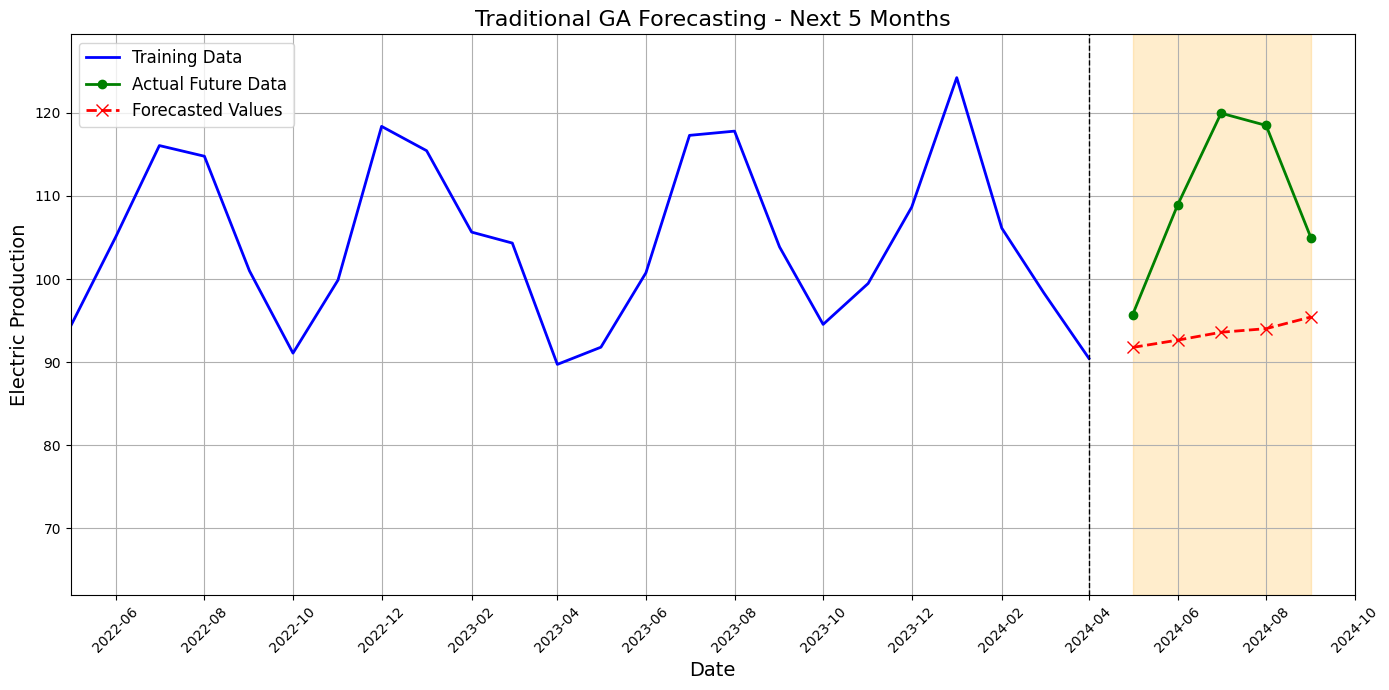

In [14]:
# Plot forecasts
plot_forecast_traditional(series[:-1], series[-1:], forecasted_values_1, n_months=1)
plot_forecast_traditional(series[:-3], series[-3:], forecasted_values_3, n_months=3)
plot_forecast_traditional(series[:-5], series[-5:], forecasted_values_5, n_months=5)

# Improved GA

In [15]:
def calculate_fitness_improved(actual, predicted, weights):
    error = actual - predicted
    weighted_error = weights * (error ** 2)
    wmse = weighted_error.sum()
    fitness = 1 / (np.sqrt(wmse) + 1e-6)  # Add small value to avoid division by zero
    return fitness

In [16]:
def genetic_algorithm_improved(train_data, generations=150, population_size=100, mutation_rate=0.03,
                               forecast_window=5, lag=5, alpha=0.9, elitism=True, elite_size=3):
    # Initialize population with random coefficients for lags
    population = [np.random.uniform(-1, 1, lag) for _ in range(population_size)]

    train_values = train_data.values
    N = len(train_values)

    forecasted_values = []
    history = list(train_values)

    for f in range(forecast_window):
        # Prepare data for current forecast
        current_train = np.array(history)
        current_N = len(current_train)

        # Define weights for current training data
        weights = np.exp(-alpha * np.linspace(0, 1, current_N))
        weights /= weights.sum()

        # Evolve population
        for generation in range(generations):
            fitness_scores = []
            for chromosome in population:
                # Generate in-sample predictions
                predictions = []
                for t in range(lag, current_N):
                    window = current_train[t - lag:t]
                    pred = np.dot(chromosome, window[::-1])
                    predictions.append(pred)

                actual = current_train[lag:]
                fitness = calculate_fitness_improved(actual, np.array(predictions), weights[lag:])
                fitness_scores.append(fitness)

            fitness_scores = np.array(fitness_scores)

            # Handle case where all fitness scores are zero
            if fitness_scores.sum() == 0:
                fitness_probs = np.ones(population_size) / population_size
            else:
                fitness_probs = fitness_scores / fitness_scores.sum()

            # Selection
            selected_indices = np.random.choice(range(population_size), size=population_size, p=fitness_probs)
            parents = [population[i] for i in selected_indices]

            # Crossover and Mutation
            new_population = []
            if elitism:
                elite_indices = fitness_scores.argsort()[-elite_size:]
                elites = [population[i] for i in elite_indices]
                new_population.extend(elites)

            while len(new_population) < population_size:
                parent1, parent2 = np.random.choice(len(parents), 2, replace=False)
                crossover_point = np.random.randint(1, lag)
                offspring1 = np.concatenate([parents[parent1][:crossover_point], parents[parent2][crossover_point:]])
                offspring2 = np.concatenate([parents[parent2][:crossover_point], parents[parent1][crossover_point:]])
                offspring1 += mutation_rate * np.random.randn(lag)
                offspring2 += mutation_rate * np.random.randn(lag)
                offspring1 = np.clip(offspring1, -5, 5)
                offspring2 = np.clip(offspring2, -5, 5)
                new_population.extend([offspring1, offspring2])

            population = new_population[:population_size]

        # Select the best chromosome
        fitness_scores = []
        for chromosome in population:
            predictions = []
            for t in range(lag, current_N):
                window = current_train[t - lag:t]
                pred = np.dot(chromosome, window[::-1])
                predictions.append(pred)
            actual = current_train[lag:]
            fitness = calculate_fitness_improved(actual, np.array(predictions), weights[lag:])
            fitness_scores.append(fitness)

        fitness_scores = np.array(fitness_scores)
        best_index = fitness_scores.argmax()
        best_chromosome = population[best_index]

        # Forecast the next value
        last_lag = np.array(history[-lag:])[::-1]
        next_pred = np.dot(best_chromosome, last_lag)
        forecasted_values.append(next_pred)
        history.append(next_pred)

    return forecasted_values

In [17]:
def forecast_next_n_months_improved(train_data, test_data, n_months=5,
                                    generations=150, population_size=100, mutation_rate=0.03,
                                    forecast_window=5, lag=5, alpha=0.9, elitism=True, elite_size=3):
    # Forecast the next N months using improved GA
    forecasted_values = genetic_algorithm_improved(train_data, generations, population_size,
                                                   mutation_rate, forecast_window, lag,
                                                   alpha, elitism, elite_size)

    # Actual values for comparison
    actual_values = test_data[:n_months].values

    # Calculate performance metrics (MAPE, RMSE)
    mape = mean_absolute_percentage_error(actual_values, forecasted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

    # Display results
    print(f"Forecasted Values for next {n_months} months: {forecasted_values}")
    print(f"Actual Values of Last {n_months} Months: {actual_values}")
    print(f"MAPE: {mape}")
    print(f"RMSE: {rmse}")

    return forecasted_values, mape, rmse

In [18]:
print("Forecasting 1 month with Improved GA:")
forecasted_values_1_improved, mape_1_improved, rmse_1_improved = forecast_next_n_months_improved(
    train_data=series[:-1],
    test_data=series[-1:],
    n_months=1,
    generations=280,
    population_size=90,
    mutation_rate=0.03,
    forecast_window=1,
    lag=3,
    alpha=0.8,
    elitism=True,
    elite_size=3
)

print("\nForecasting 3 months with Improved GA:")
forecasted_values_3_improved, mape_3_improved, rmse_3_improved = forecast_next_n_months_improved(
    train_data=series[:-3],
    test_data=series[-3:],
    n_months=3,
    generations=400,
    population_size=120,
    mutation_rate=0.03,
    forecast_window=3,
    lag=6,
    alpha=0.9,
    elitism=True,
    elite_size=3
)

print("\nForecasting 5 months with Improved GA:")
forecasted_values_5_improved, mape_5_improved, rmse_5_improved = forecast_next_n_months_improved(
    train_data=series[:-5],
    test_data=series[-5:],
    n_months=5,
    generations=300,
    population_size=150,
    mutation_rate=0.03,
    forecast_window=5,
    lag=4,
    alpha=1,
    elitism=True,
    elite_size=3
)

Forecasting 1 month with Improved GA:
Forecasted Values for next 1 months: [110.54536060364718]
Actual Values of Last 1 Months: [104.8967]
MAPE: 0.05384974554630591
RMSE: 5.648660603647187

Forecasting 3 months with Improved GA:
Forecasted Values for next 3 months: [114.66556309841405, 109.47848054396273, 98.4414486909497]
Actual Values of Last 3 Months: [119.954  118.4844 104.8967]
MAPE: 0.06054522029310033
RMSE: 7.088592233856733

Forecasting 5 months with Improved GA:
Forecasted Values for next 5 months: [102.51542750847504, 111.90468441246773, 115.45484163791069, 106.08824277411037, 97.5524125918297]
Actual Values of Last 5 Months: [ 95.6705 108.8832 119.954  118.4844 104.8967]
MAPE: 0.06228824167057066
RMSE: 7.534296226204625


In [19]:
def plot_forecast_improved(actual_data, test_data, forecasted_values, n_months):
    # Create a date range for the forecasted values
    last_date = actual_data.index[-1]
    forecast_dates = pd.date_range(start=last_date + DateOffset(months=1), periods=n_months, freq='MS')

    # Plot the actual data
    plt.figure(figsize=(12, 6))
    plt.plot(actual_data.index, actual_data.values, label='Training Data')

    # Plot the test data (actual future data)
    plt.plot(test_data.index[:n_months], test_data.values[:n_months], label='Actual Future Data')

    # Plot the forecasted values
    plt.plot(forecast_dates, forecasted_values, label='Forecasted Values', linestyle='--')

    plt.title(f'Improved GA Forecasting - Next {n_months} Months')
    plt.xlabel('Date')
    plt.ylabel('Electric Production')
    plt.legend()
    plt.show()

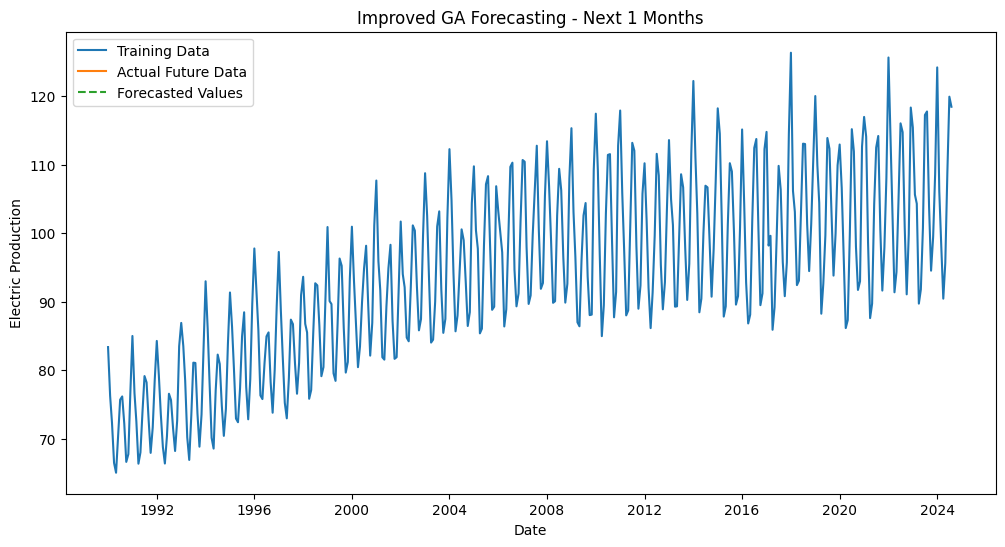

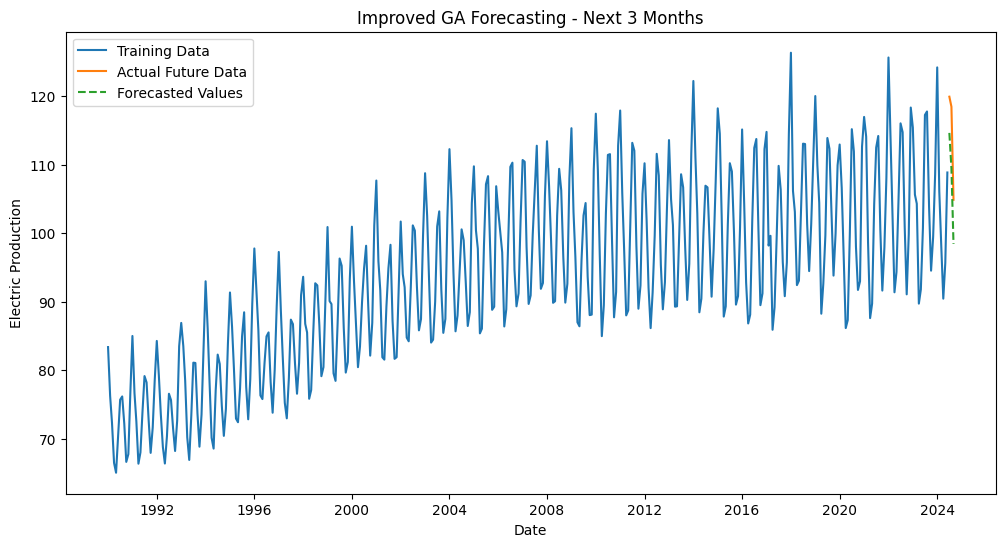

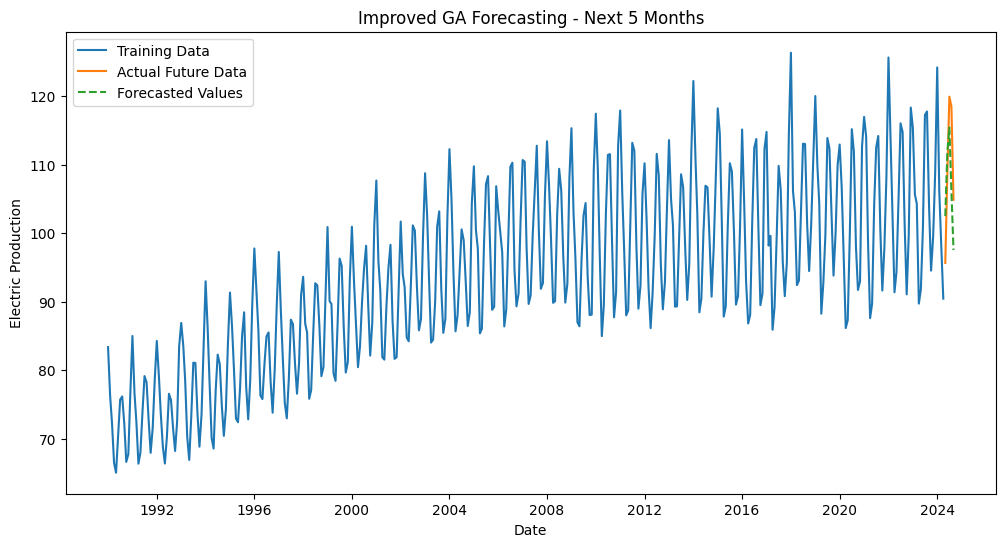

In [20]:
# Plot forecasts
plot_forecast_improved(series[:-1], series[-1:], forecasted_values_1_improved, n_months=1)
plot_forecast_improved(series[:-3], series[-3:], forecasted_values_3_improved, n_months=3)
plot_forecast_improved(series[:-5], series[-5:], forecasted_values_5_improved, n_months=5)

In [21]:
def plot_forecast_improved(actual_data, test_data, forecasted_values, n_months):
    import matplotlib.dates as mdates
    from matplotlib.dates import DateFormatter

    # Create a date range for the forecasted values
    last_date = actual_data.index[-1]
    forecast_dates = pd.date_range(start=last_date + DateOffset(months=1), periods=n_months, freq='MS')

    # Plot the actual data
    plt.figure(figsize=(14, 7))
    plt.plot(actual_data.index, actual_data.values, label='Training Data', color='blue', linewidth=2)

    # Plot the test data (actual future data)
    plt.plot(test_data.index[:n_months], test_data.values[:n_months], label='Actual Future Data',
             color='green', linestyle='-', marker='o', linewidth=2)

    # Plot the forecasted values
    plt.plot(forecast_dates, forecasted_values, label='Forecasted Values', color='red',
             linestyle='--', marker='x', markersize=8, linewidth=2)

    # Shade the forecast period
    plt.axvspan(forecast_dates[0], forecast_dates[-1], color='orange', alpha=0.2)

    # Add vertical line to indicate forecast start
    plt.axvline(x=last_date, color='black', linestyle='--', linewidth=1)

    # Set x-axis limits to focus on the recent data
    plt.xlim([actual_data.index[-24], forecast_dates[-1] + DateOffset(months=1)])

    # Improve date formatting on x-axis
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.title(f'Improved GA Forecasting - Next {n_months} Months', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Electric Production', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

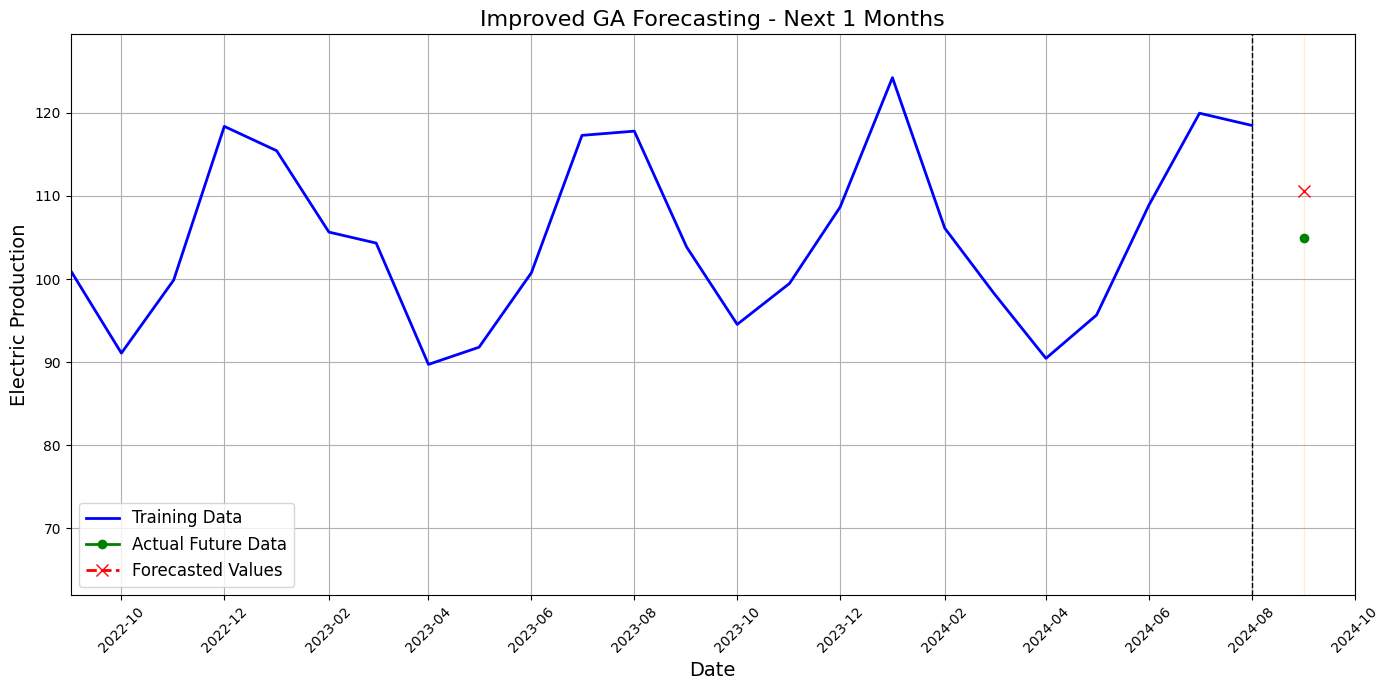

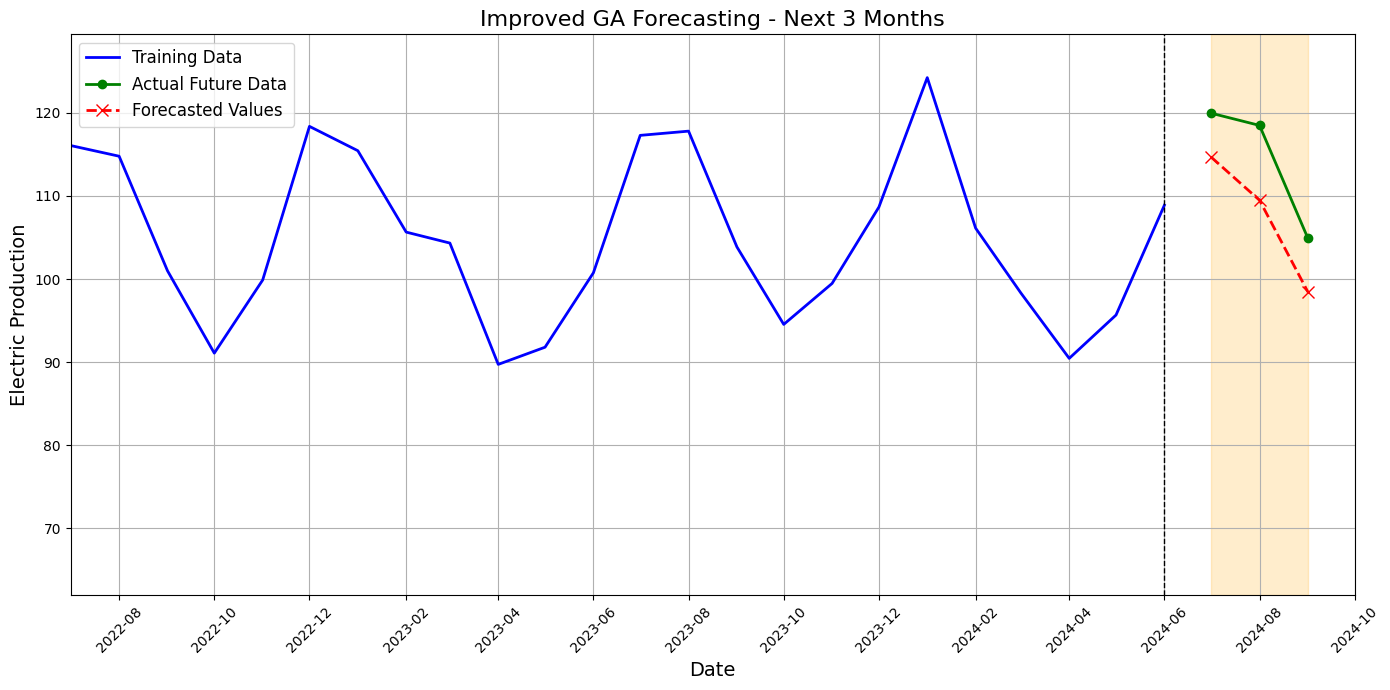

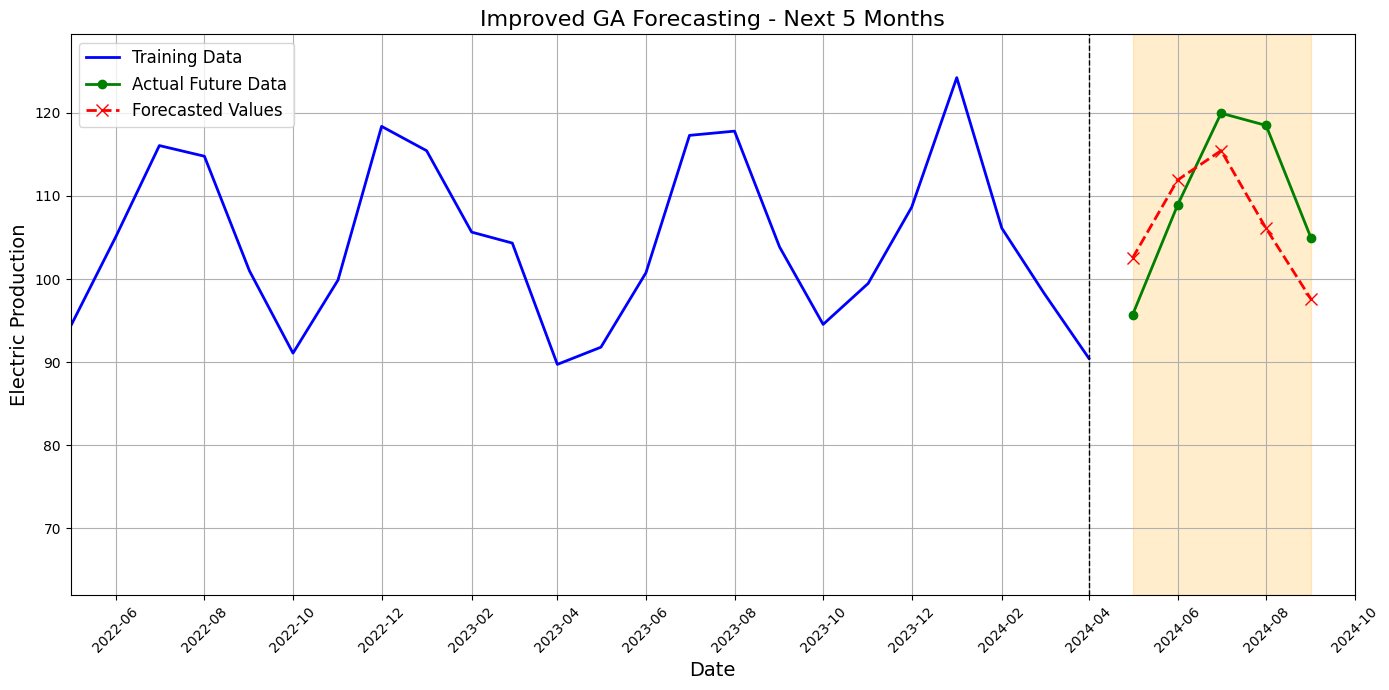

In [22]:
# Plot forecasts
plot_forecast_improved(series[:-1], series[-1:], forecasted_values_1_improved, n_months=1)
plot_forecast_improved(series[:-3], series[-3:], forecasted_values_3_improved, n_months=3)
plot_forecast_improved(series[:-5], series[-5:], forecasted_values_5_improved, n_months=5)